<a href="https://www.kaggle.com/code/tikendraw/customer-segmentation-and-visualizing-clusters?scriptVersionId=146654045" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Customer Segmentation and Analysis
Steps to solve the problem :
Visualization code is copied from this [notebook](https://www.kaggle.com/code/kushal1996/customer-segmentation-k-means-analysis) credit to the owner. in the same dataset. 
* Exploration of data. 
* Data Visualization.
* Check all Hyperparameters for better clustering and good Scores
* Clustering using K-Means and other Clustering Algorithms.
* 2D and 3D Plot of Clusters.
* Silhouette Plot

In [1]:
 
import os
import math
import random
import itertools
import warnings
from itertools import product

import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import plotly as py
import plotly.graph_objs as go
import plotly.express as px

from sklearn.cluster import (
    DBSCAN,
    AffinityPropagation,
    MeanShift,
    MiniBatchKMeans,
    KMeans,
    AgglomerativeClustering,
    estimate_bandwidth,
)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_samples, silhouette_score, ConfusionMatrixDisplay, accuracy_score
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn import cluster, mixture, metrics
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore")
py.offline.init_notebook_mode(connected = True)

random_seed = 69

np.random.seed(random_seed)
random.seed(random_seed)


In [2]:
!ls ../input/customer-segmentation-tutorial-in-python

ls: cannot access '../input/customer-segmentation-tutorial-in-python': No such file or directory


# Data

In [3]:
df = pd.read_csv('./dataset/Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [5]:
df.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [6]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [7]:
df.Gender.unique()

array(['Male', 'Female'], dtype=object)

In [8]:
df['Gender2'] = df['Gender'].map({'Female' : 0 , 'Male' : 1})

In [9]:
df2 = df.drop(['CustomerID' , 'Gender'] , axis = 1)

# Data Visualization

In [10]:
plt.style.use('fivethirtyeight')

## Histogram

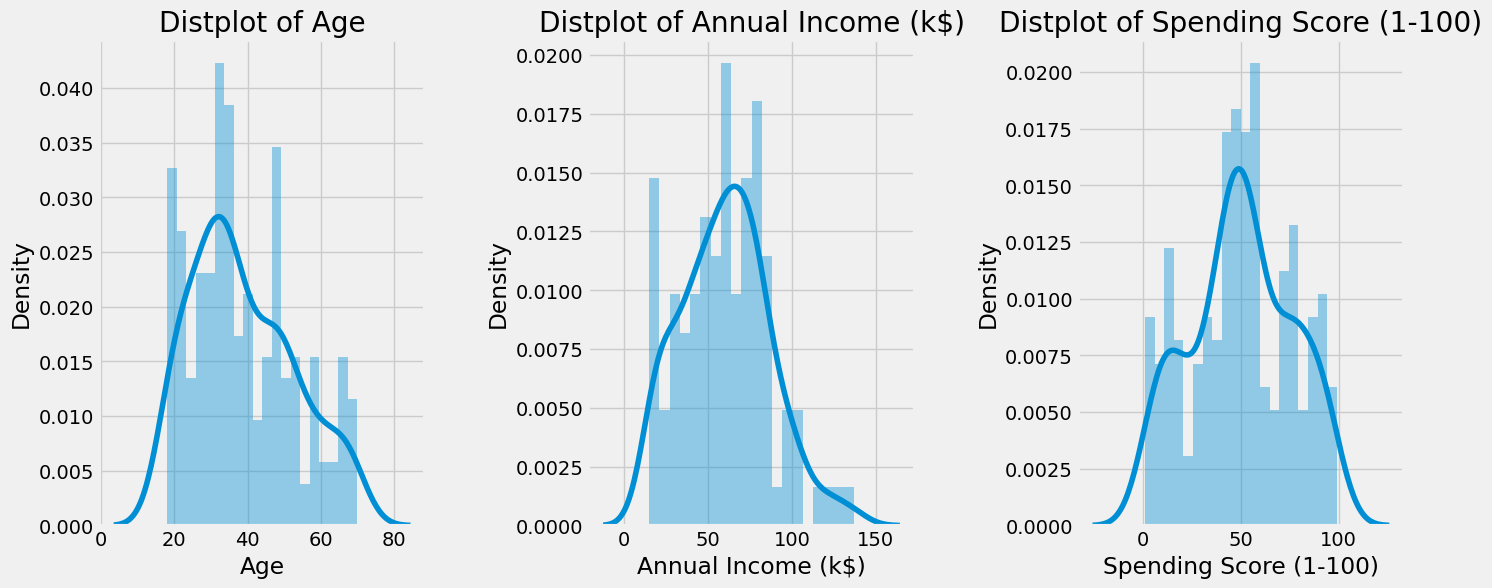

In [11]:
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.distplot(df[x] , bins = 20)
    plt.title(f'Distplot of {x}')
plt.show()

## Count Plot of Gender

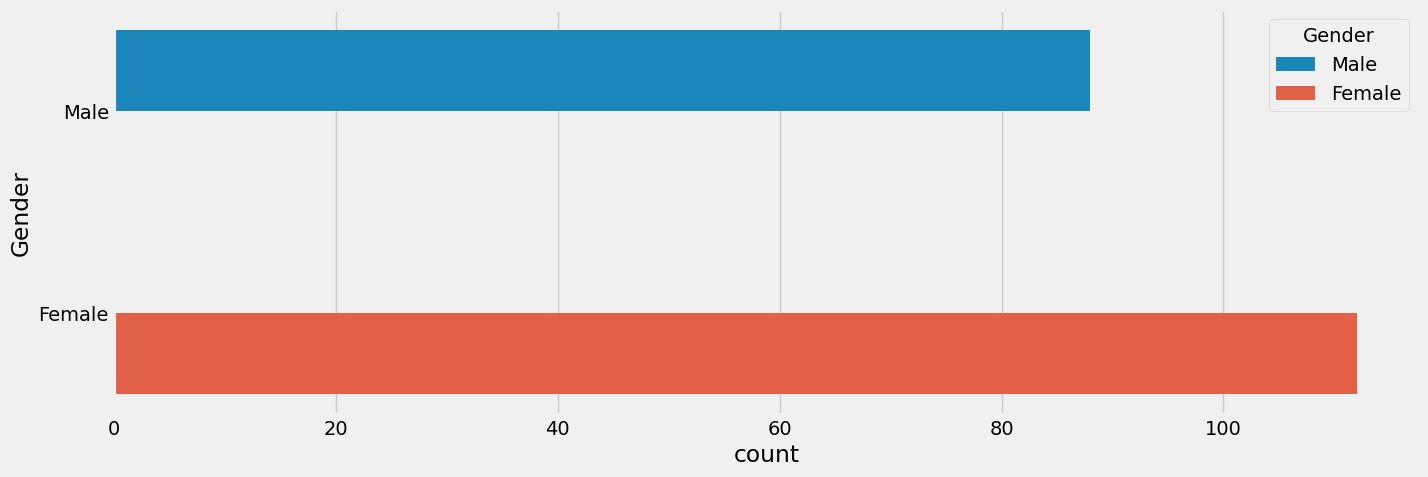

In [12]:
plt.figure(1 , figsize = (15 , 5))
sns.countplot(y = 'Gender' , data = df, hue='Gender')
plt.show()

Ploting the Relation between Age , Annual Income and Spending Score

In [13]:
# hello 

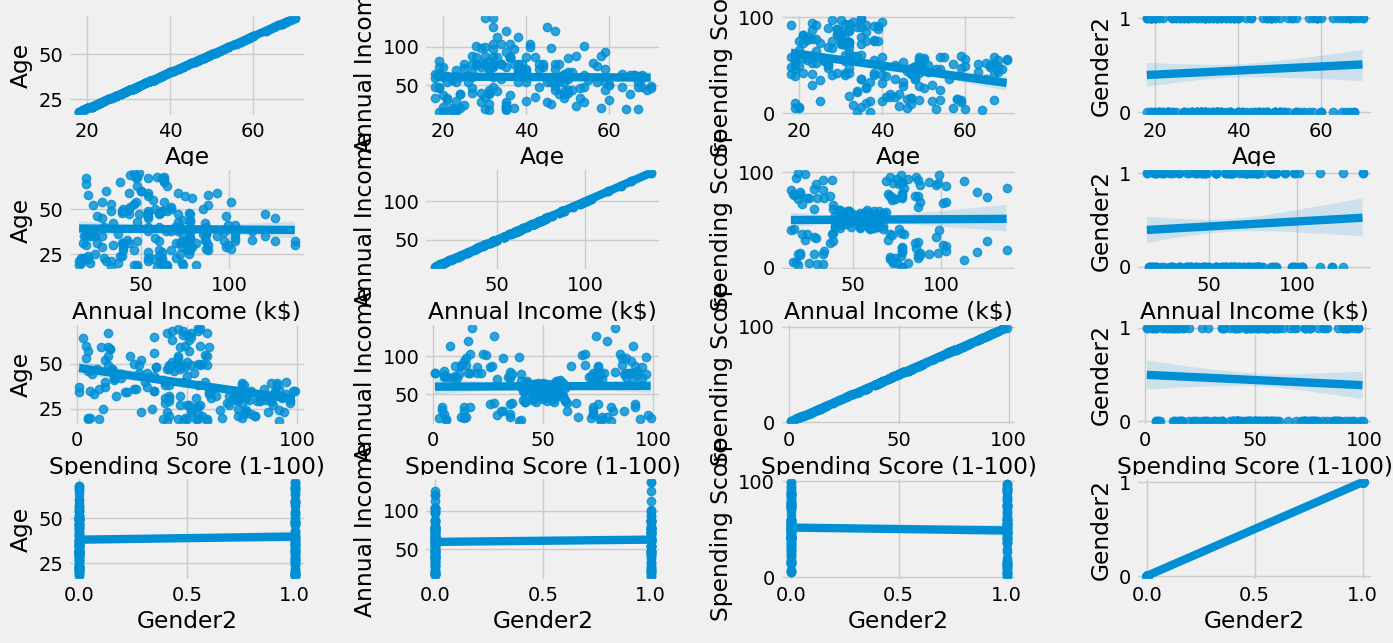

In [14]:
plt.figure(1 , figsize = (15 , 7))
n = 0 
for x in df2.columns:
    for y in df2.columns:
        n += 1
        plt.subplot(len(df2.columns) , len(df2.columns) , n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        sns.regplot(x = x , y = y , data = df)
        plt.ylabel(y.split()[0]+' '+y.split()[1] if len(y.split()) > 1 else y )
plt.show()

In [15]:
df2.corr()

,Age,Annual Income (k$),Spending Score (1-100),Gender2
Age,1.000000,-0.012398,-0.327227,0.060867
Annual Income (k$),-0.012398,1.000000,0.009903,0.056410
Spending Score (1-100),-0.327227,0.009903,1.000000,-0.058109
Gender2,0.060867,0.056410,-0.058109,1.000000


<Axes: >

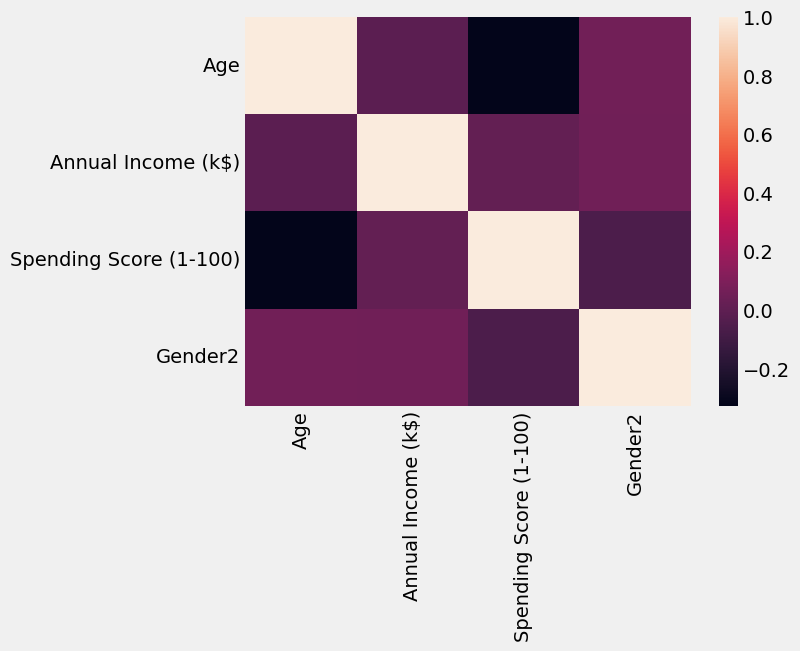

In [16]:
sns.heatmap(df2.corr())

I must say it makes good sense to see negative correlation between Age and Spending Score, People with greater age spend less (wisdom speaks)

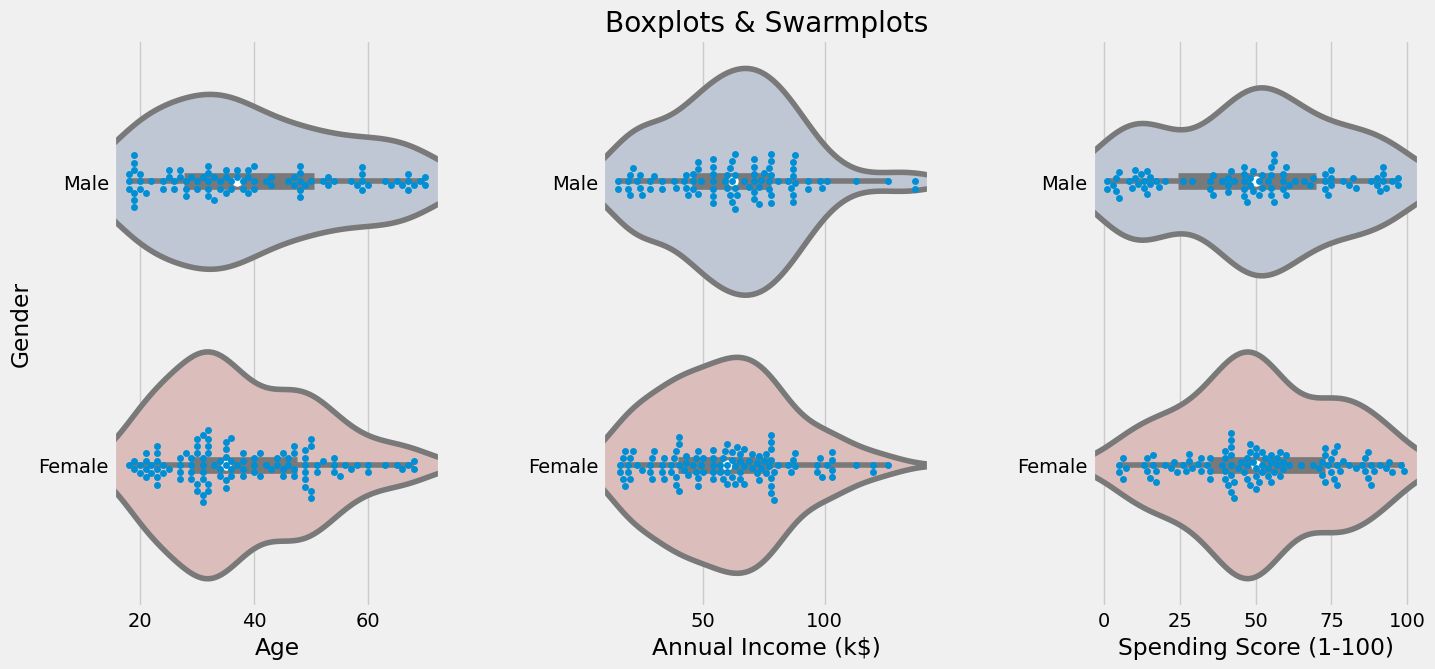

In [17]:
plt.figure(1 , figsize = (15 , 7))
n = 0 
for cols in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    n += 1 
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    sns.violinplot(x = cols , y = 'Gender' , data = df , palette = 'vlag')
    sns.swarmplot(x = cols , y = 'Gender' , data = df)
    plt.ylabel('Gender' if n == 1 else '')
    plt.title('Boxplots & Swarmplots' if n == 2 else '')
plt.show()

In [18]:
x = df2.values

# Standardize the data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Model Building

try it all

## Functions

In [19]:
def plot_silhouette(name, cluster_labels, x, ax=None, **kwargs):

    if ax is None:
        fig, ax = plt.subplots()

    # Compute silhouette score
    n_clusters = np.unique(cluster_labels).size
    
    silhouette_avg = silhouette_score(x, cluster_labels)    
    ax.set_title(f"{name} - Silhouette Score: {silhouette_avg:.2f}")

    # Compute silhouette values for each data point
    sample_silhouette_values = silhouette_samples(x, cluster_labels)

    y_lower = 10
    for i in range(cluster_labels.max() + 1):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.Spectral(float(i) / cluster_labels.max())
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7, **kwargs)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax.set_xlabel("Silhouette Coefficient Values")
    ax.set_ylabel("Cluster label")
    ax.set_title(f"{name}: Clusters({cluster_labels.max() + 1}) Silhouette Score({silhouette_avg:.2f})")
    # The vertical line for the average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_xlim(-0.2, 1)

    return ax



In [20]:

def get_cluster_centers(X, cluster_labels, n_clusters):
    centers = np.zeros((n_clusters, X.shape[1]))
    for i in range(n_clusters):
        centers[i] = np.mean(X[cluster_labels == i], axis=0)
    return centers

In [21]:
def plot_scatter_2d(x, cluster_labels, ax=None, random_state=42, **kwargs):
    n_clusters = len(np.unique(cluster_labels))
        
    if x.shape[-1] < 2:
        x = PolynomialFeatures(2).fit_transform(x)

    if x.shape[-1] != 2:
        x = TSNE(n_components=2, random_state=random_state).fit_transform(x)
        
    if ax is None:
        fig, ax = plt.subplots()
        
    if 'c' not in kwargs:
        kwargs['c'] = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

    ax.scatter(x[:, 0], x[:, 1], **kwargs)
    
    centers = get_cluster_centers(x, cluster_labels, n_clusters)
    ax.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers,1):
        ax.scatter(c[0], c[1], marker="$%d$" % i)

    return ax

In [22]:

def plot_scatter_3d(x, cluster_labels, n_clusters=None, ax=None, random_state=42,**kwargs):
    
    
    if n_clusters is None:
        n_clusters = len(np.unique(cluster_labels))

    if x.shape[-1] < 3:
        x = PolynomialFeatures(2).fit_transform(x)
        
    if x.shape[-1] != 3:
        x = TSNE(n_components=3, random_state=random_state).fit_transform(x)
        
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
    if 'c' not in kwargs:
        kwargs['c'] = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)


    ax.scatter(X[:, 0], X[:, 1], X[:, 2], **kwargs)

    centers = get_cluster_centers(X, cluster_labels, n_clusters)
    ax.scatter(
        centers[:, 0],
        centers[:, 1],
        centers[:, 2],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers, 1):
        ax.scatter(c[0], c[1], c[2], marker="$%d$" % i)

    return ax

In [23]:
def plot_datapoints(x, y, n_components=2, **kwargs):
    
    if n_components not in [2, 3]:
        raise ValueError("n_components must be in [2, 3]")
        
    if x.shape[-1] != n_components:
        x = TSNE(n_components=n_components, random_state=42).fit_transform(x)
    
    x = pd.DataFrame(x, columns=["x", "y", "z"] if n_components == 3 else ["x", "y"])
    x['cluster']=y
    x['cluster'] = x['cluster'].astype('category')
    if n_components == 2:
        fig=px.scatter(data_frame=x, x='x', y='y', color='cluster', symbol='cluster', **kwargs)
    elif n_components == 3:
        fig=px.scatter_3d(data_frame=x, x='x', y='y', z='z', color='cluster', symbol='cluster', **kwargs)
    
    fig.show()


# Tune

In [24]:
bandwidth = [estimate_bandwidth(x_scaled, quantile=quantile, n_samples=10) for quantile in np.linspace(0.35, 1.0, 10)]

In [25]:
bandwidth

[1.6327490378927465,
 2.066380931911182,
 2.066380931911182,
 2.15674589503544,
 2.426318086244577,
 2.7087152452708496,
 2.7087152452708496,
 2.925433593915991,
 3.4040782290687703,
 4.085696524791209]

In [26]:
# np.linspace(0.5,1, 10)
np.arange(2,20)

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19])

In [33]:
params = {
    'ap': {
        'damping': [0.5       , 0.55444444, 0.60888889, 0.66333333, 0.71777778,
       0.77222222, 0.82666667, 0.88111111, 0.93555556, 0.99      ] ,
        'convergence_iter': [10, 12, 14, 16, 18, 20, 22, 24, 15] ,
        'affinity': ['euclidean'],
        'random_state':[random_seed],

    },
    'kmeans': {
        'n_clusters': [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
        'init':['k-means++', 'random'], 
        'n_init': ['auto'],
        'tol':[0.001, 0.01, 0.1],
    },

    'meanshift':{
        'bandwidth':bandwidth,
    },
    'dbscan':{
#         'eps':[0.51, 0.6, 0.7, 0.8, 0.9, 0.99],
        'eps':[0.5       , 0.55555556, 0.61111111, 0.66666667, 0.72222222,
       0.77777778, 0.83333333, 0.88888889, 0.94444444, 1.        ],
        'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
    },
    'spectral':{
        'eigen_solver':['arpack', 'lobpcg'],
        'n_clusters': [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
        'n_init':[ 5,  7,  9, 11, 13, 15, 17, 19],
        'gamma':[0.5       , 0.665, 0.831, 0.996, 1.162,
       1.327, 1.493, 1.658, 1.824, 1.99      ],
#         'affinity':['rbf', 'nearest_neighbors', 'precomputed_nearest_neighbors'],
        'n_neighbors': [ 5,  7,  9, 11, 13, 15, 17, 19],
        'random_state':[random_seed],

    },
    'agg':{
        'n_clusters': [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
#         'metric': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'],
        'linkage': ['ward', 'complete', 'average', 'single'],
        'compute_distances': [True, False]
    },
    'hdbscan':{
        'min_cluster_size': [10, 15, 20], 
        'min_samples': [None, 5, 10, 15],
        'metric': ['euclidean', 'manhattan'], #, 'cosine'], 'precomputed'], 
        'alpha': [1.0, 0.5, 1.5],
        'algorithm': ['auto', 'brute', 'kdtree', 'balltree'],
        'cluster_selection_method': ['eom', 'leaf'],
    },
    'birch':{
        'threshold': [0.1, 0.3, 0.5, 0.7],
        'branching_factor': [10, 30, 50, 70],
        'n_clusters': [3, 4, 5, 6, 7, 8, 9],
    },
    'optics':{
#         'max_eps': np.linspace(0.1, 0.99, 10),
        'metric': ['cityblock', 'euclidean', 'l1', 'l2', 'manhattan'],
        'p': [1, 2, 3],
        'cluster_method': ['xi', 'dbscan'],
#         'eps': [None, 0.1, 0.5, 1.0, 2.0],
        'xi': [0.01, 0.05, 0.1, 0.2],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [10, 30, 50, 100]
    },
    'gmm':{
        'n_components': [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
        'covariance_type': ['full', 'tied', 'diag', 'spherical'],
        'tol': [1e-4, 1e-3, 1e-2, 1e-1],
        'reg_covar': [1e-7, 1e-6, 1e-5],
        'n_init': [1, 5, 10],
        'init_params': ['kmeans', 'k-means++', 'random'],
        'random_state':[random_seed],
    },
    'bgmm':{
        'n_components': [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],

        'covariance_type': ['full', 'tied', 'diag', 'spherical'],
        'tol': [1e-4, 1e-3, 1e-2, 1e-1],
        'reg_covar': [1e-7, 1e-6, 1e-5],
        'n_init': [1, 5, 10],
        'init_params': ['kmeans', 'k-means++', 'random']
    },
    'bkmeans':{
                'n_clusters': [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],

        'init': ['k-means++','random'],
        'n_init': [1, 5, 10],
        'tol': [1e-4, 1e-3, 1e-2],
        'algorithm': [ 'elkan', 'lloyd'],
        'bisecting_strategy': ['biggest_inertia', 'largest_cluster'],
    },
    'mini_batch_kmeans':{
        'n_clusters': [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
        'init': ['k-means++','random'],
        'batch_size': [2, 4, 8, 16],
        'random_state':[random_seed],
    }
}

In [34]:
models = {
    "kmeans": KMeans(),
    "ap": AffinityPropagation(),
    'gmm':mixture.GaussianMixture(),
    'bgmm':mixture.BayesianGaussianMixture(),
    "meanshift": MeanShift(),
    'dbscan': DBSCAN(),
    'spectral':cluster.SpectralClustering(),
    'agg': cluster.AgglomerativeClustering(),
    'birch': cluster.Birch(),
#     'hdbscan':cluster.HDBSCAN(), #uncomment if using sklearn >=1.3
    'optics':cluster.OPTICS(),
    'bkmeans':cluster.BisectingKMeans(),
    'mini_batch_kmeans':cluster.MiniBatchKMeans(),
}

In [79]:
class ClusterRandomizedSearch:
    def __init__(self, model, param_distributions, n_iter=10, scoring='silhouette_score', random_state=None):
        """
        Initializes an instance of the class with the provided model, parameter distributions, and optional arguments.
        Sets up the scoring, random state, results, combinations, used combinations, n_iter, and model name attributes.

        Args:
            model:sklearn model: The model to be used for clustering.
            param_distributions:dict : A dictionary of parameter distributions for the model.
            n_iter (optional):int : The number of iterations for the search. Defaults to 10.
            scoring (optional):list : The scoring metric(s) to be used for evaluation. Defaults to 'silhouette_score'.
                            values: [silhouette_score', 'davies_bouldin_score', 'calinski_harabasz_score']
                            first metric will be used to score as best params and model.
            random_state (optional): The random seed for reproducibility.

        Returns:
            None

        Raises:
            ValueError: If scoring is not a string or a list of strings.

        Example:
            ```python
            model = MyModel()
            param_distributions = {'param1': [1, 2, 3], 'param2': [4, 5, 6]}
            search = Search(model, param_distributions, n_iter=5, scoring='accuracy')
            ```
        """

        self.model = model
        self.param_distributions = param_distributions

        if isinstance(scoring, str):
            scoring = [scoring]
        elif not isinstance(scoring, list):
            raise ValueError(f"Scoring must be a string or a list of strings. Values can be {self.get_scorer()}")

        self.scoring = scoring
        self.random_state = random_state
        self.results = []
        self.combinations = self.get_all_combinations(self.param_distributions)
        random.shuffle(self.combinations)
        self.used_combinations = set()
        self.n_iter = min(n_iter, len(self.combinations))
        self.model_name = model.__class__.__name__
        
    def fit(self, X):
        np.random.seed(self.random_state)
        for _ in range(self.n_iter):
            params = self.combinations.pop()
            
            try: 
                model = self.model.set_params(**params)
                labels = model.fit_predict(X)
            except Exception as e:
                print('Model: ', self.model_name)
                print('Params: ', params)
                raise e
                
            n_clusters = np.unique(labels).size
            
            all_scores = {}
            for scoring_ in self.scoring:
                score = self._evaluate_score(X, labels, scoring_)
                all_scores.update(score)
            self.results.append({'params': params, 'name': self.model_name, 'n_clusters':n_clusters, **all_scores})

        self.best_result = max(self.results,default=np.nan, key=lambda x: x[self.scoring[0]])


    @property
    def best_params_(self):
        return self.best_result['params']

    @property
    def best_scores_(self):
        return {i:self.best_result[i] for i in self.scoring}

    @property
    def best_estimator_(self):
        return self.model.set_params(**self.best_params_)

    @property
    def n_clusters_(self):
        return self.best_result['n_clusters']
    
    def _get_random_params(self):
        for param in self.combinations:
            yield {key: value for key, value in param.items()}

    def get_all_combinations(self, parameter_dict):
        parameter_names = list(parameter_dict.keys())
        parameter_values = list(parameter_dict.values())

        combinations = list(product(*parameter_values))
        return [{param_name: value for param_name, value in zip(parameter_names, combo)} for combo in combinations]
    
    def get_scorer(self):
            return {'silhouette_score', 'davies_bouldin_score', 'calinski_harabasz_score'}
        
    def _evaluate_score(self, X, labels, scoring):
        n_clusters = np.unique(labels).size
        
        if n_clusters == 1:
            score=np.nan
        elif scoring == 'silhouette_score':
            score = silhouette_score(X, labels)
        elif scoring == 'davies_bouldin_score':
            score = metrics.davies_bouldin_score(X, labels)
        elif scoring == 'calinski_harabasz_score':
            score = metrics.calinski_harabasz_score(X, labels)
        else:
            raise ValueError(f"Invalid scoring metric: {scoring}")

        return {scoring: score}
    
    def results_(self):        
        results_df = pd.DataFrame(self.results)
        param_columns = list(self.param_distributions.keys())
        for param_column in param_columns:
            results_df[f'param_{param_column}'] = results_df['params'].apply(lambda x: x[param_column])

        return results_df
    


In [80]:
scorrr = [ 'calinski_harabasz_score' , 'silhouette_score', 'davies_bouldin_score']

In [81]:
model_grid_search = {}
n_iter=150
for i in models:
    print(i)
    tuner = ClusterRandomizedSearch(models[i], params[i], n_iter, scoring=scorrr, random_state=42)
    tuner.fit(x_scaled)

    print('Total Combinations: ',len(tuner.get_all_combinations(params[i])))
    print('Best Parameters:', tuner.best_params_)
    print('Best Score(sco):', tuner.best_scores_)
    print('Clusters:',tuner.n_clusters_)
    
    model_grid_search[i] = tuner
    print()


kmeans
Total Combinations:  66
Best Parameters: {'n_clusters': 12, 'init': 'random', 'n_init': 'auto', 'tol': 0.01}
Best Score(sco): {'calinski_harabasz_score': 90.42296723589803, 'silhouette_score': 0.4229083264585975, 'davies_bouldin_score': 0.8537852476689484}
Clusters: 12

ap
Total Combinations:  90
Best Parameters: {'damping': 0.99, 'convergence_iter': 22, 'affinity': 'euclidean', 'random_state': 69}
Best Score(sco): {'calinski_harabasz_score': nan, 'silhouette_score': nan, 'davies_bouldin_score': nan}
Clusters: 1

gmm
Total Combinations:  5184
Best Parameters: {'n_components': 11, 'covariance_type': 'spherical', 'tol': 0.001, 'reg_covar': 1e-05, 'n_init': 1, 'init_params': 'kmeans', 'random_state': 69}
Best Score(sco): {'calinski_harabasz_score': 91.37181764461951, 'silhouette_score': 0.4304267656491777, 'davies_bouldin_score': 0.8133811472146536}
Clusters: 11

bgmm
Total Combinations:  5184
Best Parameters: {'n_components': 12, 'covariance_type': 'spherical', 'tol': 0.1, 'reg_co

In [82]:
big_results_df = pd.DataFrame()
for model in model_grid_search:
    a = model_grid_search[model].results_()
    aa = a.sort_values('silhouette_score', ascending=False).head(3)
    print(' ')
    print(model)
    pp = aa[['params', 'name', 'n_clusters']+scorrr]
    display(aa)
    
    big_results_df = pd.concat([big_results_df, pp])

 
kmeans


,params,name,n_clusters,calinski_harabasz_score,silhouette_score,davies_bouldin_score,param_n_clusters,param_init,param_n_init,param_tol
50,"{'n_clusters': 12, 'init': 'random', 'n_init':...",KMeans,12,90.202141,0.427110,0.836915,12,random,auto,0.10
40,"{'n_clusters': 12, 'init': 'k-means++', 'n_ini...",KMeans,12,90.208436,0.425885,0.839065,12,k-means++,auto,0.01
60,"{'n_clusters': 12, 'init': 'random', 'n_init':...",KMeans,12,90.422967,0.422908,0.853785,12,random,auto,0.01


 
ap


,params,name,n_clusters,calinski_harabasz_score,silhouette_score,davies_bouldin_score,param_damping,param_convergence_iter,param_affinity,param_random_state
46,"{'damping': 0.88111111, 'convergence_iter': 24...",AffinityPropagation,16,91.302113,0.413365,0.813995,0.881111,24,euclidean,69
62,"{'damping': 0.77222222, 'convergence_iter': 22...",AffinityPropagation,16,91.302113,0.413365,0.813995,0.772222,22,euclidean,69
26,"{'damping': 0.82666667, 'convergence_iter': 18...",AffinityPropagation,16,91.302113,0.413365,0.813995,0.826667,18,euclidean,69


 
gmm


,params,name,n_clusters,calinski_harabasz_score,silhouette_score,davies_bouldin_score,param_n_components,param_covariance_type,param_tol,param_reg_covar,param_n_init,param_init_params,param_random_state
86,"{'n_components': 13, 'covariance_type': 'tied'...",GaussianMixture,13,87.865813,0.430728,0.790143,13,tied,0.0010,0.00001,10,kmeans,69
93,"{'n_components': 13, 'covariance_type': 'tied'...",GaussianMixture,13,87.865813,0.430728,0.790143,13,tied,0.0001,0.00001,10,kmeans,69
37,"{'n_components': 11, 'covariance_type': 'spher...",GaussianMixture,11,91.371818,0.430427,0.813381,11,spherical,0.0010,0.00001,1,kmeans,69


 
bgmm


,params,name,n_clusters,calinski_harabasz_score,silhouette_score,davies_bouldin_score,param_n_components,param_covariance_type,param_tol,param_reg_covar,param_n_init,param_init_params
7,"{'n_components': 12, 'covariance_type': 'spher...",BayesianGaussianMixture,11,91.396956,0.430473,0.813218,12,spherical,0.1000,1.000000e-06,10,kmeans
67,"{'n_components': 13, 'covariance_type': 'tied'...",BayesianGaussianMixture,12,90.980490,0.430022,0.817394,13,tied,0.0100,1.000000e-05,5,kmeans
20,"{'n_components': 11, 'covariance_type': 'tied'...",BayesianGaussianMixture,11,90.958594,0.429466,0.812280,11,tied,0.0001,1.000000e-07,10,kmeans


 
meanshift


,params,name,n_clusters,calinski_harabasz_score,silhouette_score,davies_bouldin_score,param_bandwidth
4,{'bandwidth': 1.6327490378927465},MeanShift,3,54.006704,0.26226,1.459046,1.632749
0,{'bandwidth': 4.085696524791209},MeanShift,1,NaN,NaN,NaN,4.085697
1,{'bandwidth': 2.7087152452708496},MeanShift,1,NaN,NaN,NaN,2.708715


 
dbscan


,params,name,n_clusters,calinski_harabasz_score,silhouette_score,davies_bouldin_score,param_eps,param_algorithm
30,"{'eps': 0.88888889, 'algorithm': 'ball_tree'}",DBSCAN,3,32.909312,0.254586,3.760493,0.888889,ball_tree
33,"{'eps': 0.88888889, 'algorithm': 'auto'}",DBSCAN,3,32.909312,0.254586,3.760493,0.888889,auto
38,"{'eps': 0.88888889, 'algorithm': 'brute'}",DBSCAN,3,32.909312,0.254586,3.760493,0.888889,brute


 
spectral


,params,name,n_clusters,calinski_harabasz_score,silhouette_score,davies_bouldin_score,param_eigen_solver,param_n_clusters,param_n_init,param_gamma,param_n_neighbors,param_random_state
125,"{'eigen_solver': 'arpack', 'n_clusters': 10, '...",SpectralClustering,10,81.612786,0.399958,0.846001,arpack,10,13,0.996,9,69
95,"{'eigen_solver': 'lobpcg', 'n_clusters': 10, '...",SpectralClustering,10,81.612786,0.399958,0.846001,lobpcg,10,19,0.996,9,69
8,"{'eigen_solver': 'arpack', 'n_clusters': 12, '...",SpectralClustering,12,77.268483,0.399612,0.805563,arpack,12,7,1.824,11,69


 
agg


,params,name,n_clusters,calinski_harabasz_score,silhouette_score,davies_bouldin_score,param_n_clusters,param_linkage,param_compute_distances
46,"{'n_clusters': 11, 'linkage': 'ward', 'compute...",AgglomerativeClustering,11,87.503011,0.425177,0.798712,11,ward,False
80,"{'n_clusters': 11, 'linkage': 'ward', 'compute...",AgglomerativeClustering,11,87.503011,0.425177,0.798712,11,ward,True
26,"{'n_clusters': 12, 'linkage': 'ward', 'compute...",AgglomerativeClustering,12,87.023944,0.424403,0.823211,12,ward,True


 
birch


,params,name,n_clusters,calinski_harabasz_score,silhouette_score,davies_bouldin_score,param_threshold,param_branching_factor,param_n_clusters
15,"{'threshold': 0.5, 'branching_factor': 70, 'n_...",Birch,9,81.80029,0.40012,0.89812,0.5,70,9
94,"{'threshold': 0.5, 'branching_factor': 30, 'n_...",Birch,9,81.80029,0.40012,0.89812,0.5,30,9
35,"{'threshold': 0.5, 'branching_factor': 50, 'n_...",Birch,9,81.80029,0.40012,0.89812,0.5,50,9


 
optics


,params,name,n_clusters,calinski_harabasz_score,silhouette_score,davies_bouldin_score,param_metric,param_p,param_cluster_method,param_xi,param_algorithm,param_leaf_size
118,"{'metric': 'l1', 'p': 3, 'cluster_method': 'xi...",OPTICS,14,22.272222,0.159597,1.440315,l1,3,xi,0.01,kd_tree,10
25,"{'metric': 'cityblock', 'p': 3, 'cluster_metho...",OPTICS,14,22.272222,0.159597,1.440315,cityblock,3,xi,0.01,auto,50
88,"{'metric': 'manhattan', 'p': 1, 'cluster_metho...",OPTICS,14,22.272222,0.159597,1.440315,manhattan,1,xi,0.01,brute,50


 
bkmeans


,params,name,n_clusters,calinski_harabasz_score,silhouette_score,davies_bouldin_score,param_n_clusters,param_init,param_n_init,param_tol,param_algorithm,param_bisecting_strategy
46,"{'n_clusters': 11, 'init': 'random', 'n_init':...",BisectingKMeans,11,88.807620,0.422659,0.841579,11,random,5,0.0010,elkan,biggest_inertia
35,"{'n_clusters': 11, 'init': 'k-means++', 'n_ini...",BisectingKMeans,11,89.024404,0.422046,0.842558,11,k-means++,5,0.0001,elkan,biggest_inertia
58,"{'n_clusters': 11, 'init': 'random', 'n_init':...",BisectingKMeans,11,88.875418,0.420398,0.848500,11,random,10,0.0001,elkan,largest_cluster


 
mini_batch_kmeans


,params,name,n_clusters,calinski_harabasz_score,silhouette_score,davies_bouldin_score,param_n_clusters,param_init,param_batch_size,param_random_state
70,"{'n_clusters': 12, 'init': 'k-means++', 'batch...",MiniBatchKMeans,12,74.521500,0.384067,0.933481,12,k-means++,4,69
94,"{'n_clusters': 11, 'init': 'k-means++', 'batch...",MiniBatchKMeans,11,81.090131,0.383168,0.977608,11,k-means++,16,69
86,"{'n_clusters': 13, 'init': 'random', 'batch_si...",MiniBatchKMeans,13,78.549536,0.377359,0.898483,13,random,16,69


# Big DF

        'Higher Calinski-Harabasz score relates to a model with better-defined clusters.'
        'Higher Silhouette score relates to a model with better-defined clusters.'
        'Lower Davies-Bouldin index relates to a model with better separation between the clusters.'

In [83]:
big_results_df.sort_values('calinski_harabasz_score', ascending=False).head(10)

,params,name,n_clusters,calinski_harabasz_score,silhouette_score,davies_bouldin_score
7,"{'n_components': 12, 'covariance_type': 'spher...",BayesianGaussianMixture,11,91.396956,0.430473,0.813218
37,"{'n_components': 11, 'covariance_type': 'spher...",GaussianMixture,11,91.371818,0.430427,0.813381
46,"{'damping': 0.88111111, 'convergence_iter': 24...",AffinityPropagation,16,91.302113,0.413365,0.813995
62,"{'damping': 0.77222222, 'convergence_iter': 22...",AffinityPropagation,16,91.302113,0.413365,0.813995
26,"{'damping': 0.82666667, 'convergence_iter': 18...",AffinityPropagation,16,91.302113,0.413365,0.813995
67,"{'n_components': 13, 'covariance_type': 'tied'...",BayesianGaussianMixture,12,90.980490,0.430022,0.817394
20,"{'n_components': 11, 'covariance_type': 'tied'...",BayesianGaussianMixture,11,90.958594,0.429466,0.812280
60,"{'n_clusters': 12, 'init': 'random', 'n_init':...",KMeans,12,90.422967,0.422908,0.853785
40,"{'n_clusters': 12, 'init': 'k-means++', 'n_ini...",KMeans,12,90.208436,0.425885,0.839065
50,"{'n_clusters': 12, 'init': 'random', 'n_init':...",KMeans,12,90.202141,0.427110,0.836915


# Fine tuned models

In [84]:
fine_tunes_models = {}

In [85]:
for name, cv in model_grid_search.items():
    fine_tunes_models[name] = cv.best_estimator_

# 2D Plots

In [86]:
len(fine_tunes_models)

12

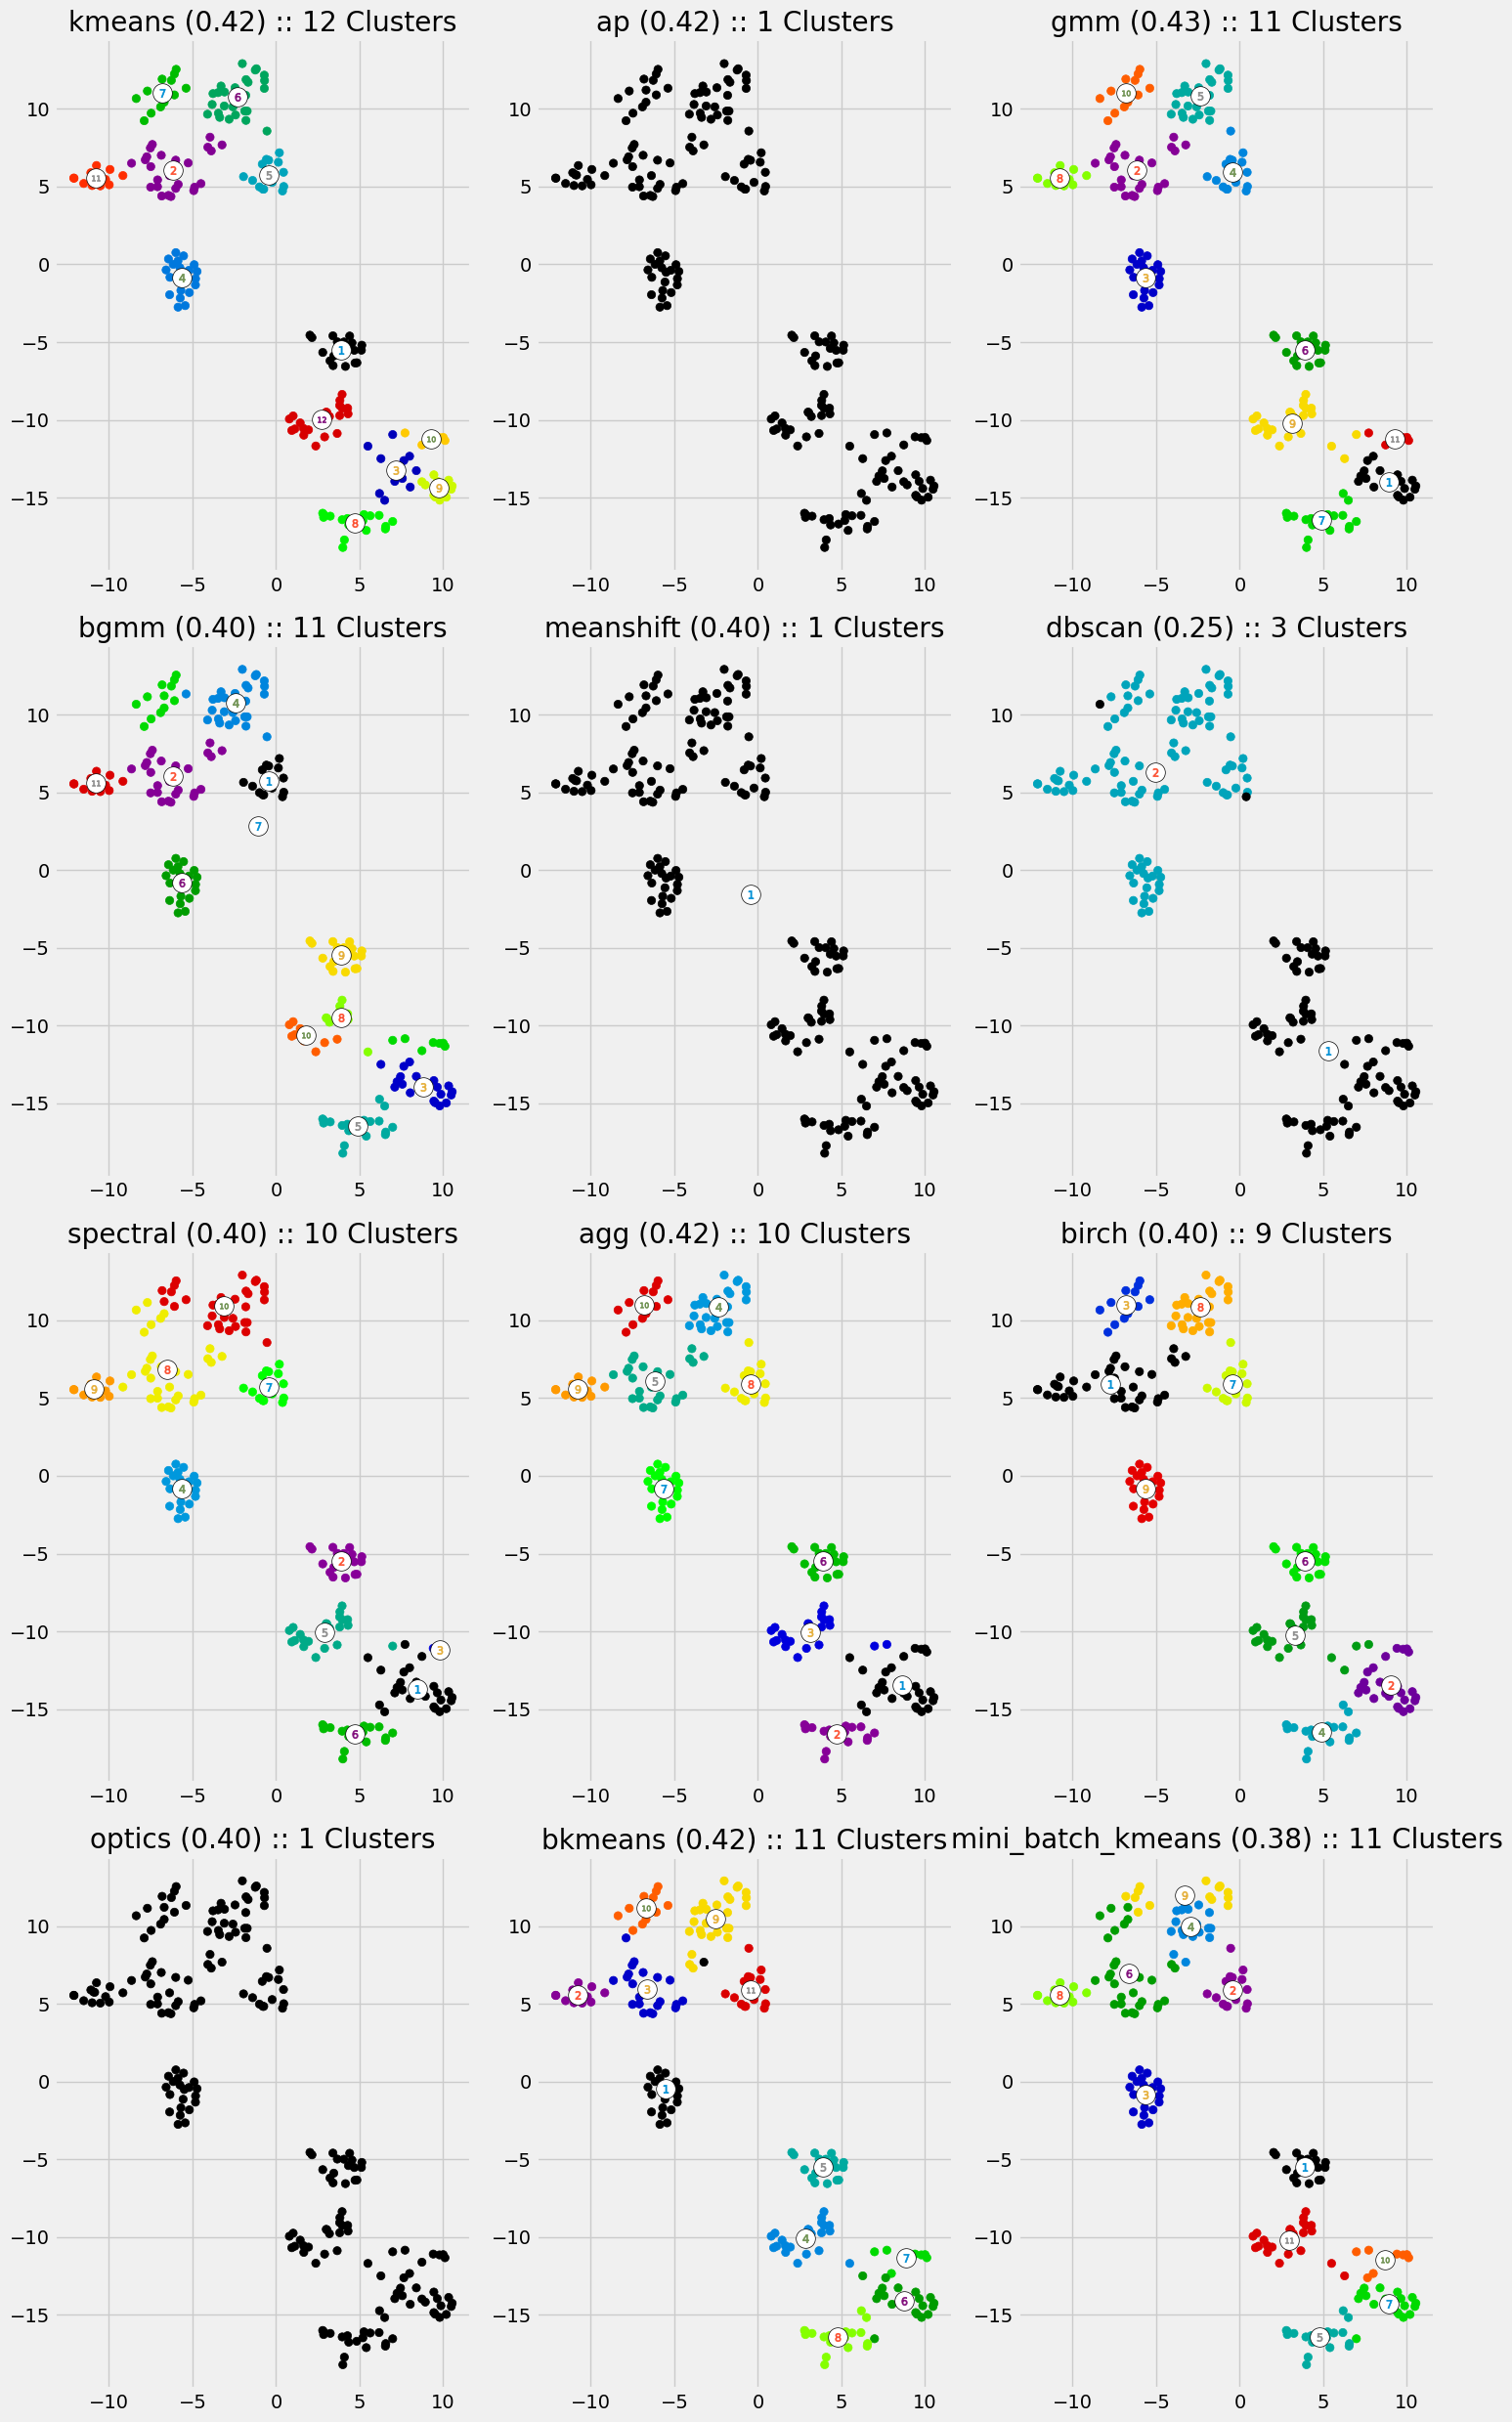

In [87]:
n_cols = 3
n_rows = math.ceil(fine_tunes_models.__len__() / n_cols)
# Create a 4x3 grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 25))

plot_n = 0
for name, model in fine_tunes_models.items():
    model.fit(x_scaled)

    if hasattr(model, "labels_"):
        y_pred = model.labels_.astype(int)
    else:
        y_pred = model.predict(x_scaled)

    cluster_num = len(np.unique(y_pred))
    
    if cluster_num > 1:
        
        score = silhouette_score(x_scaled, y_pred)

    plot_scatter_2d(x_scaled, y_pred, ax=axes[plot_n // 3, plot_n % 3])
    axes[plot_n // 3, plot_n % 3].set_title(f'{name} ({score:.2f}) :: {cluster_num} Clusters')

    plot_n += 1

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# 3D Plots

In [88]:
nn = 1
for name, model in fine_tunes_models.items():
    model.fit(x_scaled)

    if hasattr(model, "labels_"):
        y_pred = model.labels_.astype(int)
    else:
        y_pred = model.predict(x_scaled)  # Use x_scaled, not X
    
    n_clusters = np.unique(y_pred).size
    if n_clusters > 1:
        score = silhouette_score(x_scaled, y_pred)
    plot_datapoints(x_scaled, y_pred, n_components=3, title=f'{nn}. {name}({score:.2f})::({n_clusters} Clusters)')
        
    nn += 1
#     print(nn)

Some of the Datapoints are in same cluster but in different places. It just may be because of projection in lower dimensions.

# Sihouette Plots

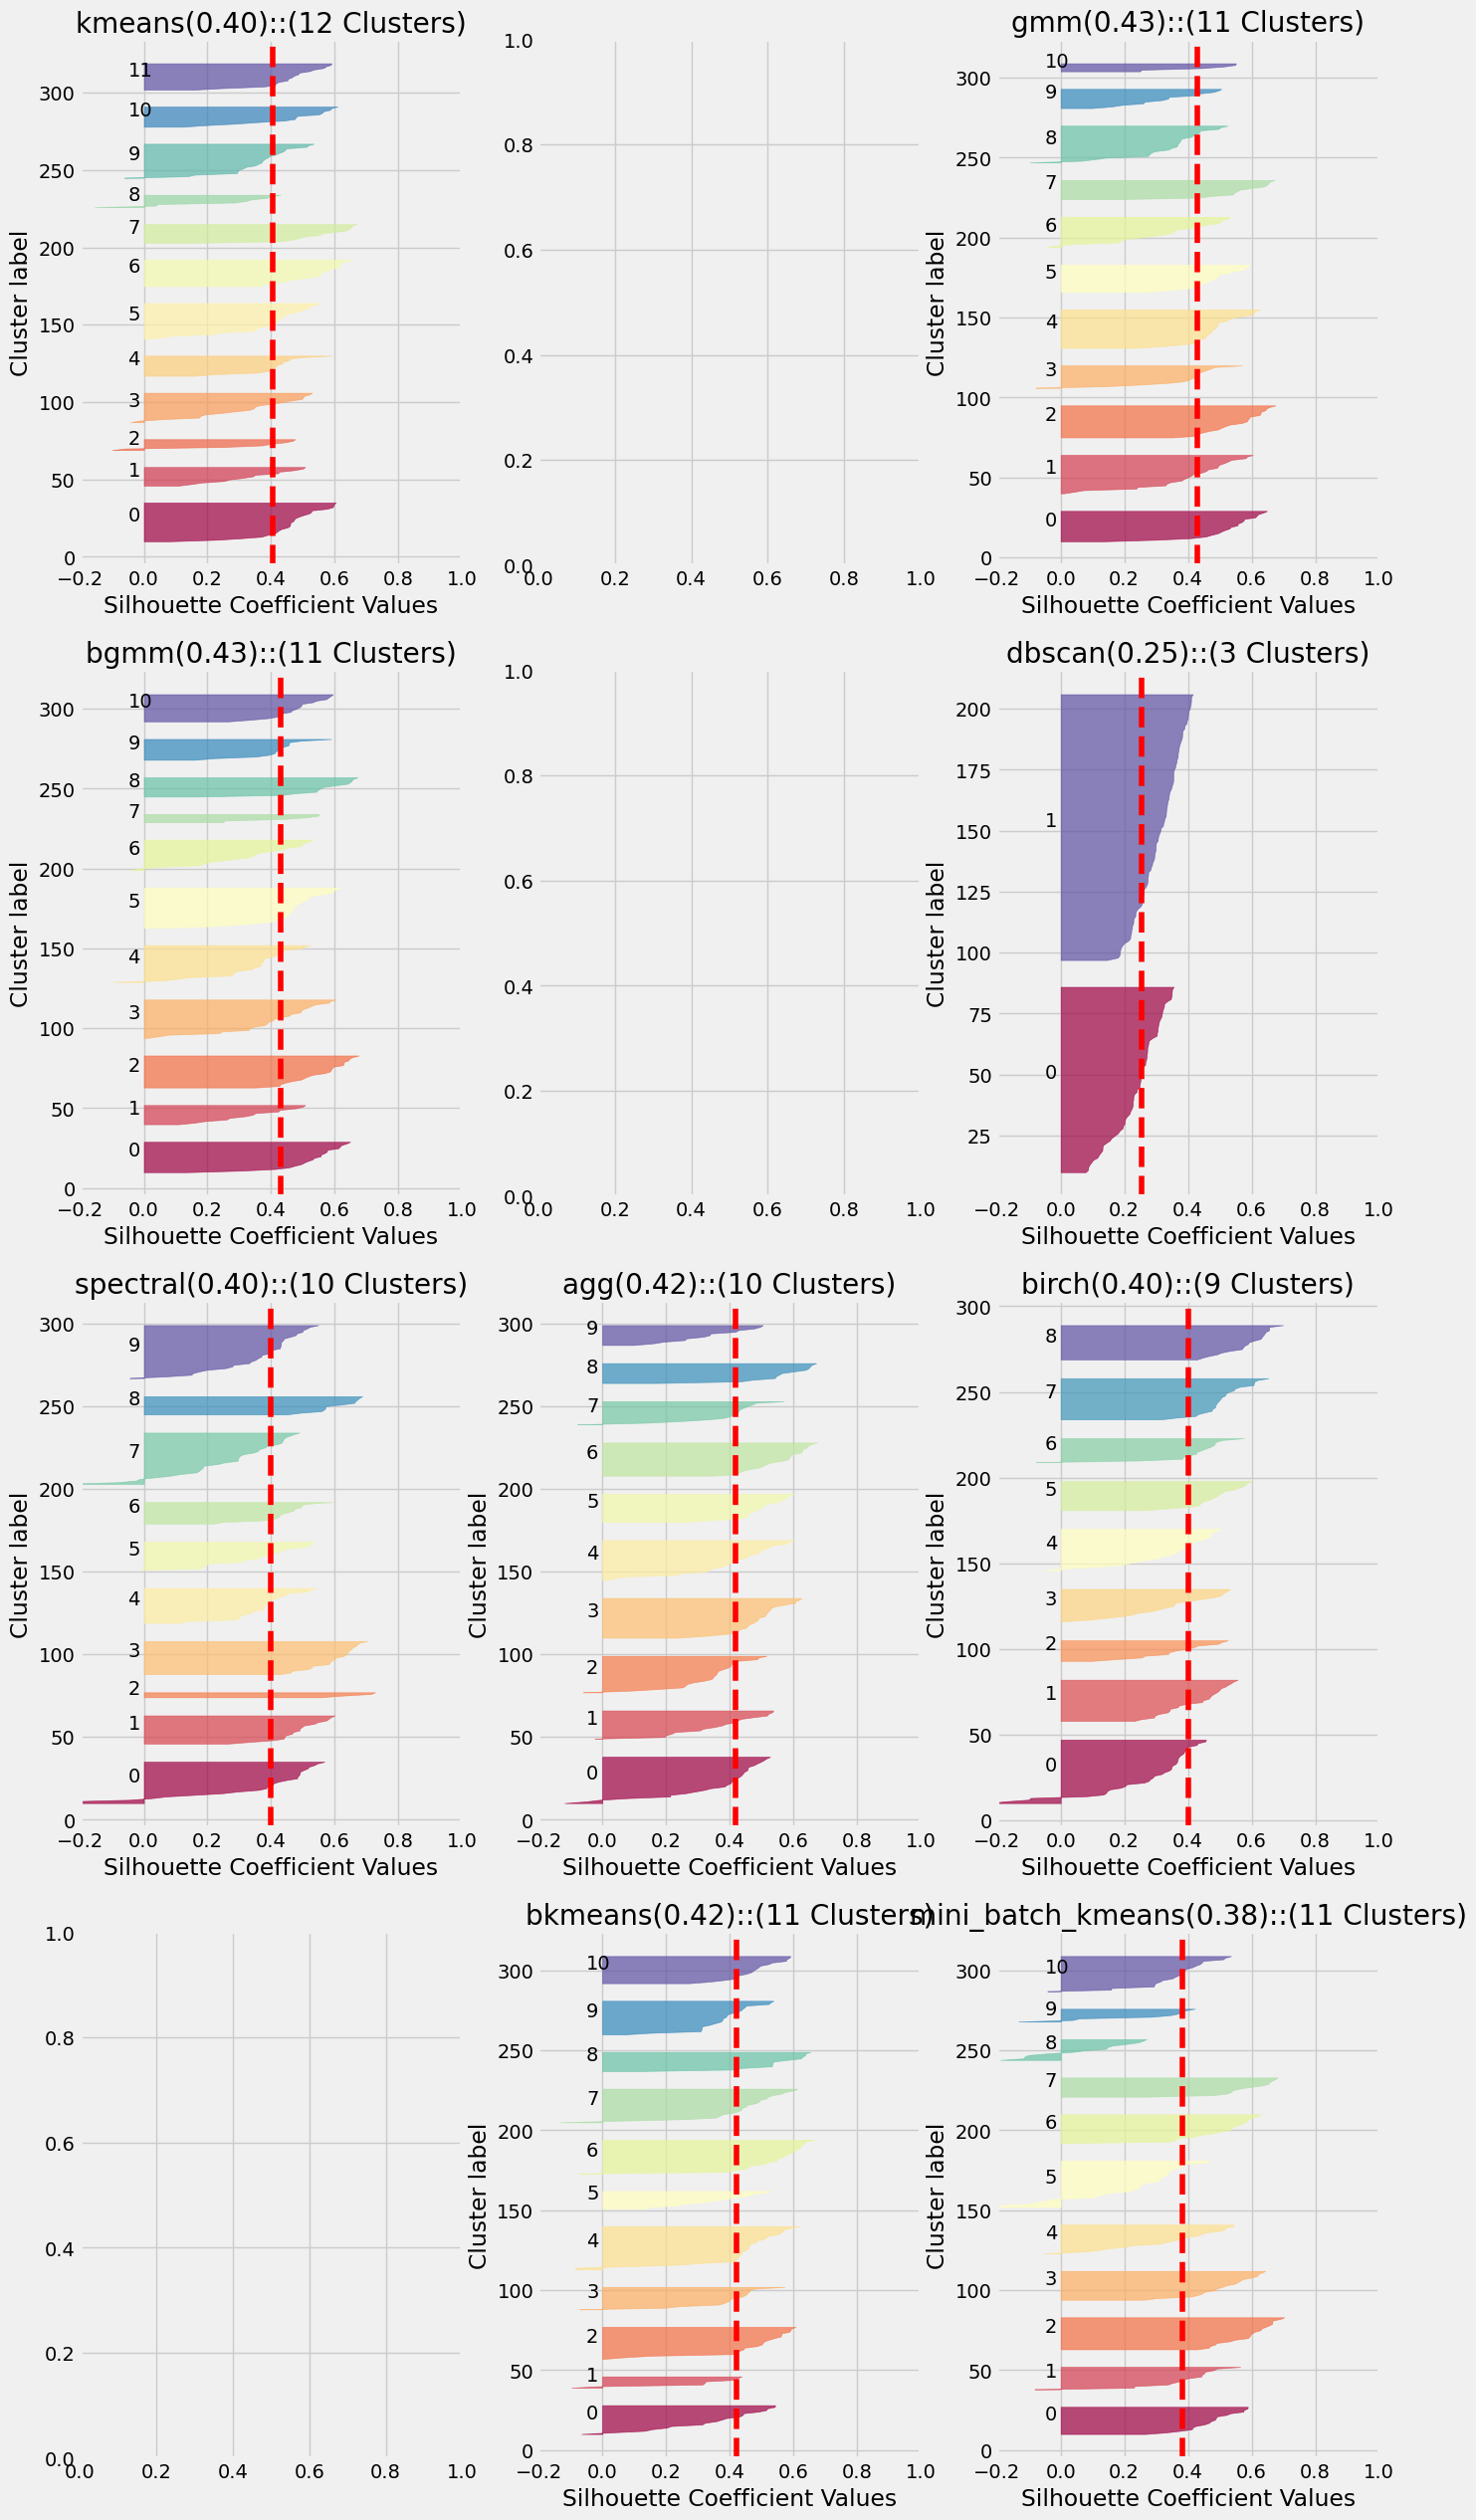

In [89]:



fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 30))

plot_n = 0
for name, model in fine_tunes_models.items():
    model.fit(x_scaled)

    if hasattr(model, "labels_"):
        y_pred = model.labels_.astype(int)
    else:
        y_pred = model.predict(x_scaled)
    
    n_clusters = len(np.unique(y_pred))
    
    score = 0
    # wont plot for just one cluster
    if n_clusters > 1:
        score = silhouette_score(x_scaled, y_pred)
        plot_silhouette(name, y_pred, x_scaled, ax=ax[plot_n // 3, plot_n % 3])
        ax[plot_n // 3, plot_n % 3].set_title(f'{name}({score:.2f})::({n_clusters} Clusters)')

    plot_n += 1

plt.show()

# Conclusion

Given the Cluster plots and silhouette scores for each model the optimum number of well defined clusters is among 6-10.
Any model with Silhouette score above 0.35 is considered to be a good model here.

So, 

1. Kmeans (it will get higher sil score for more number of clusters, so clusters between 8-12 would be good, good number of datapoints in each group) 
2. BKmeans
3. Birch
4. BGMM
5. Spectral
6. Agg
7. GMM
8. Mini Batch Kmeans

Not in a Particular Order, but i like Birch here for two reason
1. 9 Cluster for 200 datapoints (not too many , not too less)
2. Good Scores 

# Saving the models

In [90]:
good_models = ['kmeans','mini_batch_kmeans','birch','bgmm', 'gmm','spectral','agg']

In [91]:
model_dir = Path('models')
model_dir.mkdir(exist_ok=True)

pipes  = {}
for model in good_models:
    best_one=fine_tunes_models[model]
    
    pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  
            ('scaler', StandardScaler()),  
            (model, best_one)
    ])
    pipes[model] = pipeline
    pipeline.fit(x_scaled)

    filename = model_dir/f'{model}_pipeline.pkl'
    pickle.dump(pipeline, open(filename, 'wb'))

# Testing Pipeline

Trying to Recreate the same output as above

In [102]:
a = pipes['kmeans']
a

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('kmeans',
                 KMeans(init='random', n_clusters=12, n_init='auto',
                        tol=0.01))])

In [104]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Gender2
0,1,Male,19,15,39,1
1,2,Male,21,15,81,1
2,3,Female,20,16,6,0
3,4,Female,23,16,77,0
4,5,Female,31,17,40,0


In [94]:
x[:10,:] #DATA

array([[19, 15, 39,  1],
       [21, 15, 81,  1],
       [20, 16,  6,  0],
       [23, 16, 77,  0],
       [31, 17, 40,  0],
       [22, 17, 76,  0],
       [35, 18,  6,  0],
       [23, 18, 94,  0],
       [64, 19,  3,  1],
       [30, 19, 72,  0]])

In [95]:
aa = a.fit(x)

In [96]:
aa.named_steps['kmeans'].labels_

array([ 6,  6,  9,  5,  9,  5,  9,  5,  4,  5,  4,  5,  9,  5,  4,  6,  9,
        6,  4,  5,  6,  6,  9,  6,  9,  6,  9,  6,  9,  5,  4,  5,  4,  6,
        9,  5,  9,  5,  9,  5,  8,  6,  7,  0,  9,  5,  8,  0,  0,  0,  8,
        6,  0,  7,  8,  7,  8,  7,  0,  7,  7,  6,  8,  8,  7,  6,  0,  8,
        6,  0,  7,  8,  8,  8,  7,  6,  8,  7, 11,  8,  7,  6,  7,  8, 11,
        7,  8, 11,  0,  8,  8,  6,  7,  0,  0,  6,  8, 11,  7,  6, 11,  8,
        7,  6,  7, 11,  8,  7,  7,  7,  7, 11,  0,  6, 11, 11,  8,  8,  8,
        8,  6,  0,  0,  3, 11, 10,  2,  3,  7,  3,  2,  3, 11, 10,  2, 10,
        1,  3,  2, 10,  1,  3, 11, 10,  2,  3,  7, 10,  1,  3,  2,  3,  1,
       10,  1, 10,  2, 10,  2, 10,  1, 10,  2, 10,  2, 10,  2, 10,  1,  3,
        2,  3,  2,  3,  1, 10,  2,  3,  2,  3,  1, 10,  2, 10,  1,  3,  1,
        3,  1, 10,  1, 10,  2, 10,  1, 10,  1,  3,  2,  3], dtype=int32)

In [98]:
xx_scaled = aa.named_steps['scaler'].transform(x)

In [99]:
point_names = df['CustomerID'].values.tolist()

In [ ]:
Gender	Age	Annual Income (k$)	Spending Score (1-100)

In [105]:
point_namess = df['Gender'] + ' ' + df['Age'].astype(str) + ' ' + df['Annual Income (k$)'].astype(str) + ' ' + df['Spending Score (1-100)'].astype(str)

In [106]:
plot_datapoints(xx_scaled, aa.named_steps['kmeans'].labels_, n_components=3, title='kmeans', hover_name=point_namess)

# Understanding the Clusters

In [108]:
# cluster centers
aa.named_steps['kmeans'].cluster_centers_

array([[-0.36344702, -0.34308864, -0.07431556, -0.88640526],
       [ 0.41265847,  1.21277   , -1.11029664, -0.88640526],
       [-0.06498872,  0.98587395, -1.44416206,  1.12815215],
       [-0.39989994,  1.01344075,  1.26040667,  1.12815215],
       [ 1.19491538, -1.39547433, -1.51533492,  1.12815215],
       [-0.96084556, -1.33087991,  1.17778643, -0.88640526],
       [-1.02205127, -0.75821082,  0.43783969,  1.12815215],
       [ 1.33688862, -0.1989457 , -0.1495474 ,  1.12815215],
       [ 1.12613897, -0.27106656, -0.02717509, -0.88640526],
       [ 0.19294198, -1.2985827 , -1.14553467, -0.88640526],
       [-0.47793198,  0.97284787,  1.22158511, -0.88640526],
       [-1.17936593,  0.10585655, -0.16305055, -0.88640526]])

In [109]:
# cluster centers
scaled_cluster_centers = aa.named_steps['kmeans'].cluster_centers_
cluster_centers = aa.named_steps['scaler'].inverse_transform(scaled_cluster_centers)

In [114]:
cluster_centers.astype('int')

array([[33, 51, 48,  0],
       [44, 92, 21,  0],
       [37, 86, 13,  1],
       [33, 87, 82,  1],
       [55, 24, 11,  1],
       [25, 25, 80,  0],
       [24, 40, 61,  1],
       [57, 55, 46,  1],
       [54, 53, 49,  0],
       [41, 26, 20,  0],
       [32, 86, 81,  0],
       [22, 63, 46,  0]])

## To Understand the the features responsible for clustering , We Will use classifier for feature importance

How ? 
1. Get the clusters labels and use it as classification labels
2. Use the classifier to predict the labels
3. Use the classifier to get the feature importance

In [161]:
y = aa.named_steps['kmeans'].labels_

In [248]:
xtrain, xtest, ytrain, ytest = sklearn.model_selection.train_test_split(xx_scaled, y, test_size=0.2, random_state=random_seed, stratify=y)

In [249]:
xtrain.shape, xtest.shape

((160, 4), (40, 4))

In [250]:
# knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)
knn = RandomForestClassifier(max_depth=6, n_estimators = 200, random_state=0)
knn.fit(xtrain, ytrain)

RandomForestClassifier(max_depth=6, n_estimators=200, random_state=0)

In [251]:
ypred = knn.predict(xtest)
print('accuracy on test: ', accuracy_score(ytest, ypred)*100, '%')

accuracy on test:  90.0 %


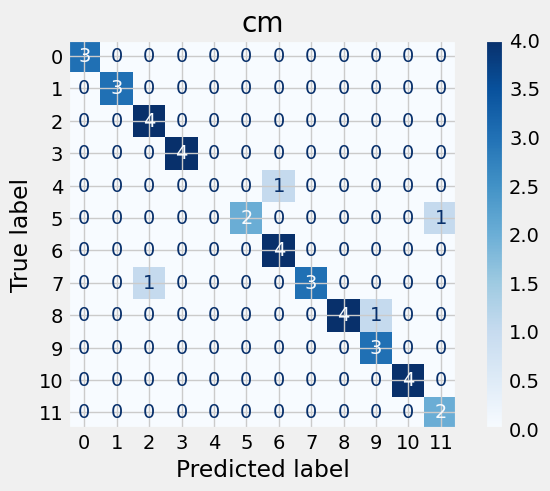

In [252]:
disp = ConfusionMatrixDisplay.from_estimator(
        knn,
        xtest,
        ytest,
        display_labels=class_names,
        cmap=plt.cm.Blues,
#         normalize=False,
    )
_=disp.ax_.set_title('cm')


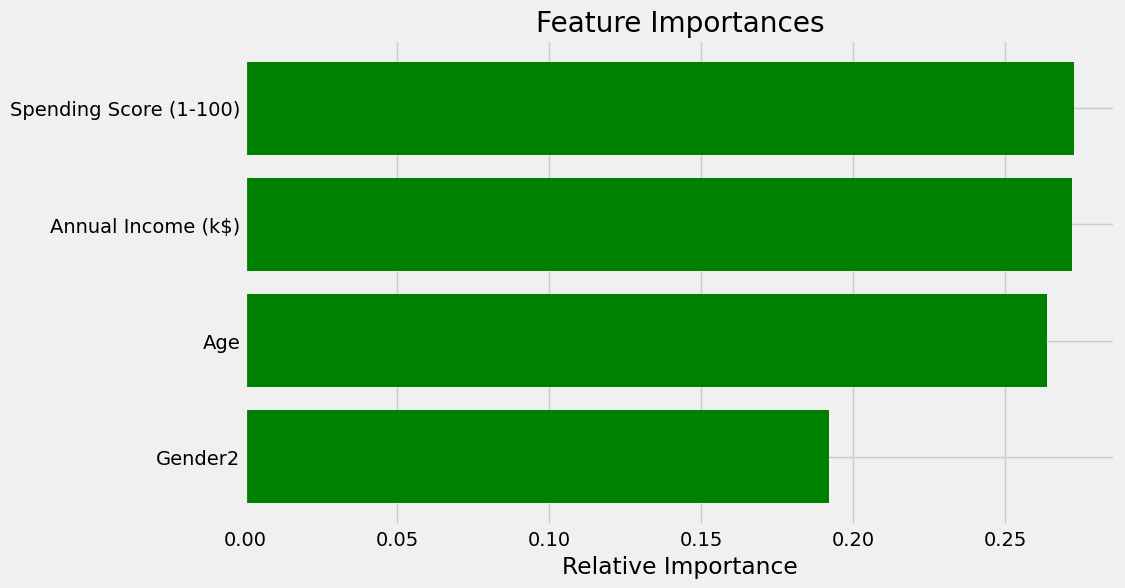

In [253]:
cls = knn
importance = cls.feature_importances_
indices = np.argsort(importance)
features = df2.columns

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importance[indices], color='green', align='center')
plt.yticks(range(len(indices)), labels=[features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Insights from plots:

1. Gender has Lowest importance because of low variance in the data.
2. Age , Annual Income, Spending Score has Higher importance (greater importance for building well defined clusters)



Finally, Any model from `kmeans`,`mini_batch_kmeans`,`birch`,`bgmm`, `gmm`,`spectral`,`agg` would be great based on the need.

------------------------------------------------------------------------------------------------------------------------------